In [1]:
import pandas as pd
import janitor as jn
import pymc3 as pm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Darwin's Finches

A research group has taken measurements of the descendants of the finches that Charles Darwin observed when he postulated the theory of evolution.

We will be using Bayesian methods to analyze this data, specifically answering the question of how quantitatively different two species of birds' beaks are.

## Data Credits

The Darwin's finches datasets come from the paper, [40 years of evolution. Darwin's finches on Daphne Major Island][data]. 

One row of data has been added for pedagogical purposes.

[data]: (https://datadryad.org/resource/doi:10.5061/dryad.g6g3h). 

### Exercise

Load the data. It is located at `../data/finch_beaks_2012.csv`.

In [2]:
# Load the data
df = pd.read_csv('../data/finch_beaks_2012.csv')

# Data cleaning methods. This is provided for you. Follow along the annotations
# to learn what's going on.
df = (jn.DataFrame(df)  # wrap dataframe in a Janitor dataframe.
      .clean_names()    # clean column names
      .rename_column('blenth', 'beak_length')  # rename blength to beak_length (readability fix)
      .rename_column('bdepth', 'beak_depth')   # rename bdepth to beak_depth (readability fix)
      .label_encode('species')  # create a `species_enc` column that has the species encoded numerically
     )

species
fortis      121
scandens    127
unknown       1
dtype: int64

I have added one row of data, simulating the discovery of an "unknown" species of finch for which beak measurements have been taken.

For pedagogical brevity, we will analyze only beak depth during the class. However, I would encourage you to perform a similar analysis for beak length as well.

In [51]:
fortis_filter = df['species'] == 'fortis'
scandens_filter = df['species'] == 'scandens'
unknown_filter = df['species'] == 'unknown'

In [5]:
with pm.Model() as beak_depth_model:
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean = pm.HalfNormal('mean', sd=100, shape=(3,))
    # Define the prior for the observed variance of the beak depths
    sd = pm.HalfCauchy('sd', beta=100, shape=(3,))
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu,
                       mu=mean[df['species_enc']], 
                       sd=sd[df['species_enc']], 
                       observed=df['beak_depth'])

### Exercise

Perform MCMC sampling to estimate the posterior distribution of each parameter.

In [6]:
with beak_depth_model:
    trace = pm.sample(2000, tuning=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, sd_log__, mean_log__]
100%|██████████| 2500/2500 [00:19<00:00, 127.40it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


### Exercise

Diagnose whether the sampling has converged or not using trace plots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c18186048>,
      dtype=object)

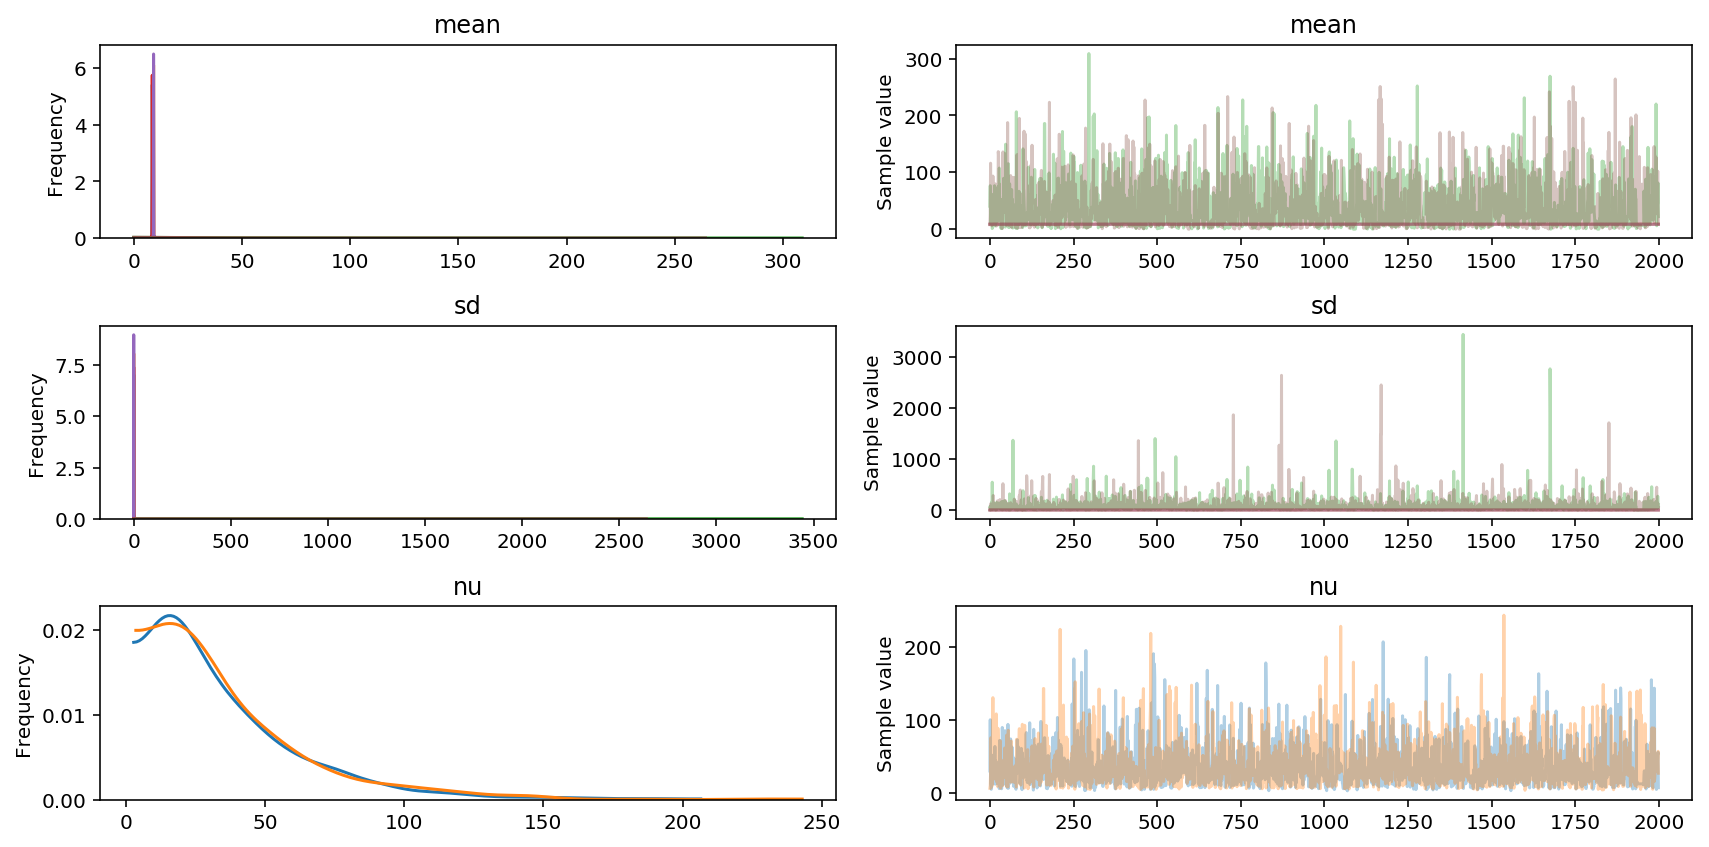

In [9]:
pm.traceplot(trace)

### Exercise

Visualize the posterior distribution over the parameters using the forest plot.

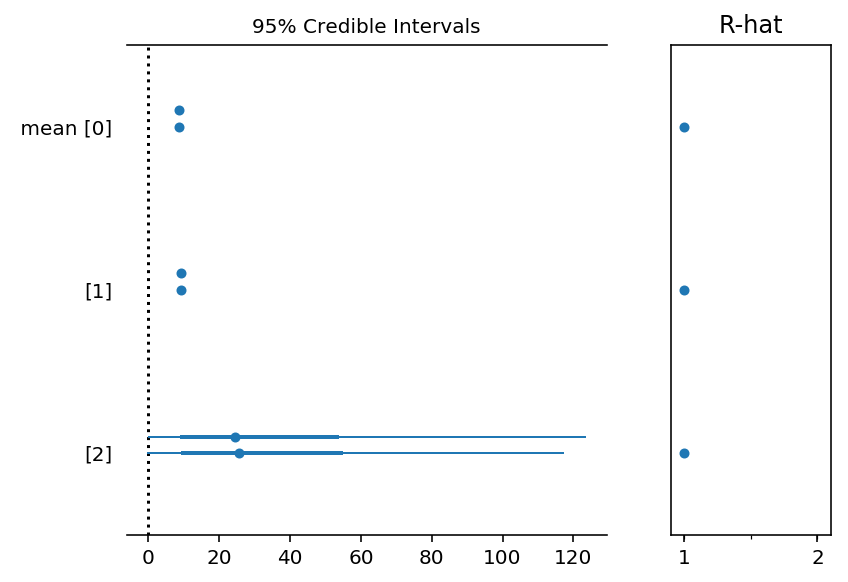

In [7]:
pm.forestplot(trace, varnames=['mean'])

### Exercise

Visualize the posterior distribution of the means. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10a8c2fd0>,
      dtype=object)

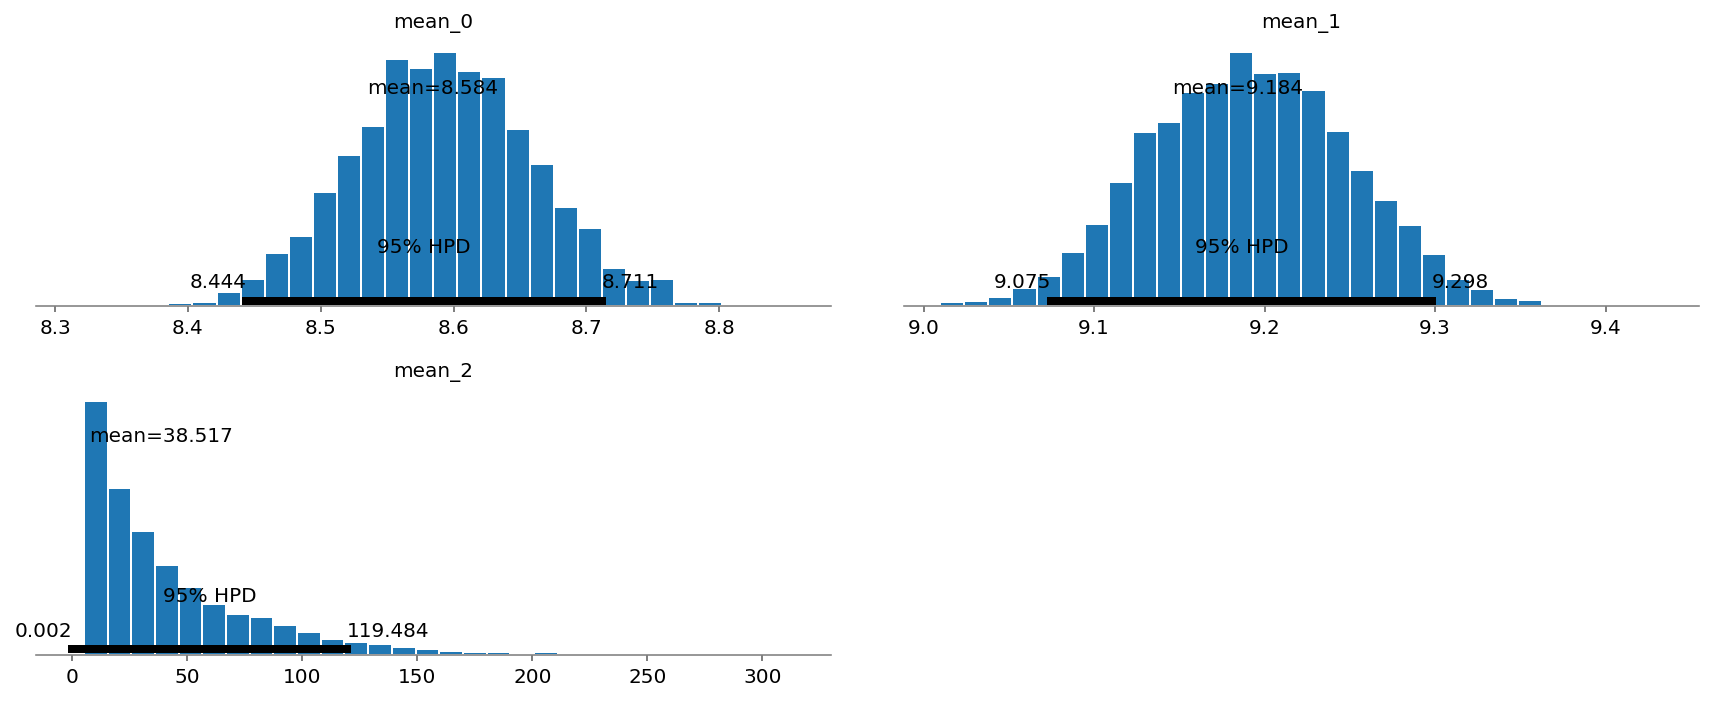

In [8]:
pm.plot_posterior(trace, varnames=['mean'])

### Exericse

Perform a posterior predictive check to visually diagnose whether the model describes the data generating process well or not.

In [50]:
samples = pm.sample_ppc(trace, model=beak_depth_model, samples=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1249.50it/s]


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

Hint: Each column in the samples (key: "likelihood") corresponds to simulated measurements of each finch in the dataset. We can use fancy indexing along the columns (axis 1) to select out simulated measurements for each category, and then flatten the resultant array to get the full estimated distribution of values for each class.

In [63]:
df[scandens_filter]['species_enc'].index

Int64Index([121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
            ...
            238, 239, 240, 241, 242, 243, 244, 245, 246, 247],
           dtype='int64', length=127)

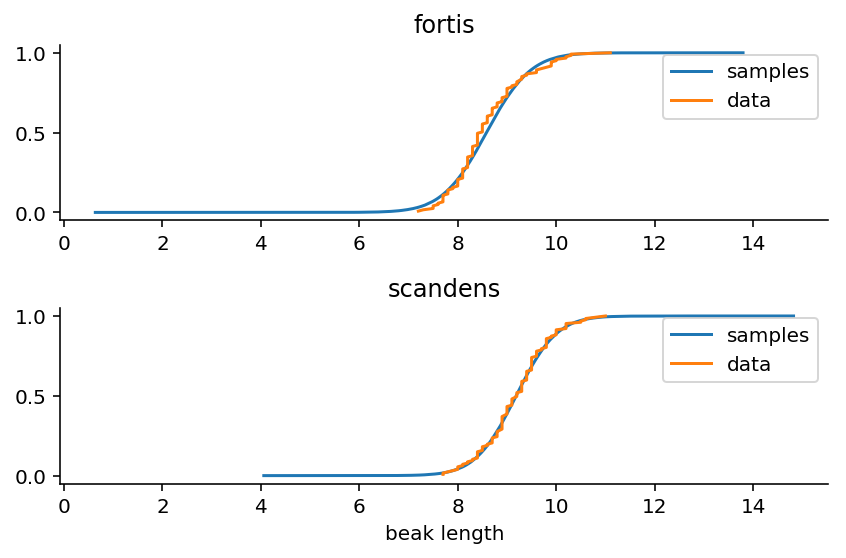

In [72]:
fig = plt.figure()
ax_fortis = fig.add_subplot(2, 1, 1)
ax_scandens = fig.add_subplot(2, 1, 2, sharex=ax_fortis)

x_s, y_s = ecdf(samples['likelihood'][:, df[fortis_filter].index].flatten())
ax_fortis.plot(x_s, y_s, label='samples')
x, y = ecdf(df[fortis_filter]['beak_depth'])
ax_fortis.plot(x, y, label='data')
ax_fortis.legend()
ax_fortis.set_title('fortis')

x_s, y_s = ecdf(samples['likelihood'][:, df[scandens_filter].index].flatten())
ax_scandens.plot(x_s, y_s, label='samples')
x, y = ecdf(df[scandens_filter]['beak_depth'])
ax_scandens.plot(x, y, label='data')
ax_scandens.legend()
ax_scandens.set_title('scandens')
ax_scandens.set_xlabel('beak length')

sns.despine()
plt.tight_layout()

## Discussion

- Is the posterior distribution for the unknown species reasonable, given what you might know about finch beaks?
- How quantitatively different are beak lengths between the fortis and scandens finch species?

## Summary

1. NumPy-like fancy indexing lets us write models in a concise fashion.
1. Posterior estimates can show up as being "unreasonable", "absurd", or at the minimum, counter-intuitive, if we do not impose the right set of assumptions on the model.
